<a href="https://colab.research.google.com/github/Tkag0001/AI_and_Machine_Learning_for_Coders/blob/main/Chapter13_Using_Tensorflow_Lite_in_Android_Apps_Part_2ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 13: Using TensorFlow Lite in Android Apps - Part 2. 🧑‍💻📱

![cover](https://www.systango.com/blog/wp-content/uploads/2020/03/Blog4.jpg)

❤️ **Hi mọi người** ❤️  

Trong **phần 1** lần trước, tụi mình đã tìm hiểu sơ bộ cũng như lập trình thử một chương trình chạy **TensorFlow** trên hệ điều hành **Android** rồi ha. 📱🤖  

Lần này, tụi mình sẽ đi **tiến xa hơn** với một ứng dụng **phức tạp hơn** tí nha. 🚀  

🔹 **Về cơ bản, các bước quy trình làm vẫn tương tự như trước**.  
🔹 **Điểm khác biệt chính** là việc tụi mình cần phải **điều chỉnh dữ liệu đầu vào** sao cho mô hình có thể hiểu được.  

👉 **Trong phần tiếp theo này, tụi mình sẽ đối diện với việc sử dụng _dữ liệu dạng hình ảnh_**! 📸🎯  

📌 Về mô hình, tụi mình sẽ lấy lại mô hình **phân loại chó mèo** ở [chương 12](https://github.com/Tkag0001/AI_and_Machine_Learning_for_Coders/blob/main/Chapter12_An_Introduction_to_TensorFlow_Lite.ipynb) nha. 🐶🐱  

✨ **Nào, không nói nhiều nữa!**  
🔥 **Tụi mình bắt tay vào làm ngay thôi!** 💪😆

# **🚀 Xây dựng mô hình**  

📌 Mọi người có thể **chạy lại code dưới đây** để **huấn luyện** và **tải mô hình về máy** nha. 🖥️📂  

💡 Đồng thời, tụi mình cũng sẽ **phân tích yêu cầu đầu vào** của mô hình để đảm bảo dữ liệu được xử lý đúng cách trước khi đưa vào dự đoán. 🧐📊  

👇 **Bắt đầu nào!** 🔥

In [1]:

#@title Cài đặt các thư viện
import numpy as np
import matplotlib.pyplot as plt
import time as timer

import tf_keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from datetime import timedelta

In [2]:
IMAGE_SIZE = (224, 224)

def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return  image, label

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
print(f"Số lượng mẫu: {num_examples}")
print(f"Số lượng nhãn: {num_classes}")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.DMD8AC_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Số lượng mẫu: 23262
Số lượng nhãn: 2


In [3]:
# Cập nhật các tập train, validation, test

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

In [4]:
# Tải MobileNetV2 với trọng số pre-trained trên ImageNet
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),  # Kích thước đầu vào của ảnh
    include_top=False,         # Loại bỏ tầng phân loại đầu ra của MobileNetV2
    weights='imagenet'         # Sử dụng trọng số pre-trained trên ImageNet
)

# Đóng băng các tầng của mô hình gốc (không huấn luyện lại)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
model_transfer_mobilenet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(num_classes, activation='softmax')
])

model_transfer_mobilenet.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
start_time = timer.time()
history = model_transfer_mobilenet.fit(train_batches, epochs=5, validation_data=validation_batches)
end_time = timer.time()

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 54s 65ms/step - accuracy: 0.9580 - loss: 0.1065 - val_accuracy: 0.9819 - val_loss: 0.0508
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 69s 56ms/step - accuracy: 0.9856 - loss: 0.0420 - val_accuracy: 0.9819 - val_loss: 0.0487
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.9857 - loss: 0.0397 - val_accuracy: 0.9837 - val_loss: 0.0475
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 0.9900 - loss: 0.0301 - val_accuracy: 0.9785 - val_loss: 0.0605
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.9895 - loss: 0.0309 - val_accuracy: 0.9811 - val_loss: 0.0567


In [7]:
# Lưu mô hình lại
model_transfer_mobilenet_path = 'model_transfer_mobilenet.h5'
model_transfer_mobilenet.save(model_transfer_mobilenet_path)

In [8]:
print(f"Thời gian huấn luyện mô hình: {str(timedelta(seconds=end_time - start_time))}")

Thời gian huấn luyện mô hình: 0:04:06.719641


In [9]:
# Load lại mô hình từ file.h5
model_transfer_mobilenet = tf.keras.models.load_model(model_transfer_mobilenet_path)
converter = tf.lite.TFLiteConverter.from_keras_model(model_transfer_mobilenet)
tflite_model_transfer = converter.convert()

Saved artifact at '/tmp/tmpbl2eqc0a'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  135987953452048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135987953451088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135988882609488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135987953451664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135987953452240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135987990208848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135987953453008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135987988388496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135987953451856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135987954385744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1359879883894

In [10]:
# Lưu mô hình TFLite
tflite_model_transfer_path = 'model_transfer_mobilenet.tflite'
with open(tflite_model_transfer_path, "wb") as f:
    f.write(tflite_model_transfer)

Mọi người nhớ download mô hình tflite về để làm tiếp các bước sau nha.

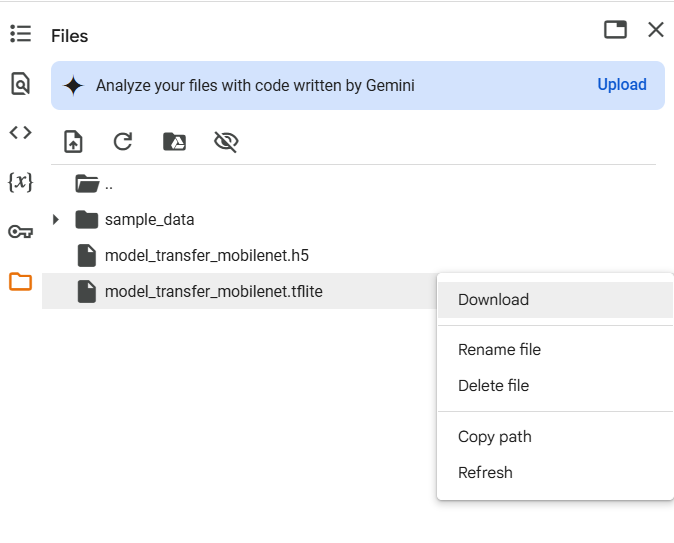

# **📊 Phân tích đầu vào của mô hình**  

Ở đây tụi mình có thể quan sát thấy dòng chuẩn hóa này:  

```python
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),  # Kích thước đầu vào của ảnh
    include_top=False,         # Loại bỏ tầng phân loại đầu ra của MobileNetV2
    weights='imagenet'         # Sử dụng trọng số pre-trained trên ImageNet
)
```  

📌 Vậy có nghĩa là kích thước ảnh đầu vào của mô hình chúng ta là **224 x 224** với **3 kênh màu**. Khi triển khai thành ứng dụng **Android**, chúng ta cũng sẽ cần phải **tuân thủ theo chuẩn đầu vào này**. 📷  

💡 Tuy nhiên, ảnh chụp từ điện thoại không phải lúc nào cũng có kích thước như vậy. Chúng có thể có kích thước bất kỳ, chẳng hạn như **395 x 500** dưới đây. 🖼️

![img](https://github.com/Tkag0001/AI_and_Machine_Learning_for_Coders/blob/main/images/Chapter_13_2/1.png?raw=true)

Do đó tụi mình sẽ cần một hàm để có thể tinh chỉnh kích thước lại về 224 x 224 nha. Và điều này có thể được thực hiện thông qua thư viện **Bitmap** trong**Android** nha.

```kotlin
val scaledBitmap = Bitmap.createScaledBitmap(bitmap, 224, 224, false)
```



📌 **Tiếp đến là kích thước Tensor nha.** 🧩  

Như mô hình đã định nghĩa trước đó, chúng ta cần đảm bảo rằng **Tensor** phải đúng định dạng **224 x 224 x 3**. Ngoài ra, trong quá trình chuẩn bị mô hình, các giá trị đầu vào đều được **chuẩn hóa** trong khoảng **0 đến 1**. Vì vậy, trong ứng dụng **Android**, chúng ta cũng phải thực hiện điều tương tự. 🎯  

📝 Để làm điều này, chúng ta có thể sử dụng đoạn code sau:  

```kotlin
val byteBuffer = ByteBuffer.allocateDirect(4 * 224 * 224 * 3)
byteBuffer.order(ByteOrder.nativeOrder())
```  

📌 Ở đây, bởi vì chúng ta đưa các giá trị về dạng **float** (0 đến 1), mà kiểu **float** có kích thước **4 byte**, nên tổng kích thước **ByteArray** sẽ là `4 x 224 x 224 x 3` nha. 📊

Bởi vì trong Android, mỗi pixel của hình ảnh được lưu dưới dạng **số nguyên 32-bit**, theo định dạng **ARGB** (Alpha, Red, Green, Blue). Ví dụ, một pixel có thể có giá trị **0x0010FF10**:  

- **00**: Giá trị **Alpha** (độ trong suốt), có thể bỏ qua.  
- **10**: Giá trị **Red (R) = 0x10**.  
- **FF**: Giá trị **Green (G) = 0xFF**.  
- **10**: Giá trị **Blue (B) = 0x10**.  

Để chuẩn hóa các giá trị màu này về khoảng **0 đến 1**, bạn chỉ cần **chia mỗi kênh màu cho 255**:  

- **Red**: 0x10 / 255 = 16 / 255 ≈ 0.06275.  
- **Green**: 0xFF / 255 = 225 / 255 = 1.0.
- **Blue**: 0x10 / 255 = 16 / 255 ≈ 0.06275.



📌 **Sau khi hiểu nguyên lý rồi, giờ chúng ta bắt tay vào code nha.** 💻✨  

🔹 Đầu tiên, chúng ta cần chuyển đổi ảnh **Bitmap** thành một mảng số nguyên có kích thước **224 × 224**, rồi trích xuất các giá trị pixel bằng API `getPixels()`:  

```kotlin
val intValues = IntArray(224 * 224)
scaledBitmap.getPixels(intValues, 0, 224, 0, 0, 224, 224)
```  

🔹 Tiếp theo, chúng ta **lặp qua mảng này**, đọc từng pixel và **chuẩn hóa** chúng thành giá trị `float` từ **0 đến 1**.  

📝 **Dịch bit (bit shifting) để trích xuất từng kênh màu từ giá trị ARGB 32-bit**:  
- **Red (R)**: `val red = (pixel shr 16) and 0xFF`  
- **Green (G)**: `val green = (pixel shr 8) and 0xFF`  
- **Blue (B)**: `val blue = pixel and 0xFF`  

Sau khi trích xuất, chúng ta chuẩn hóa giá trị về khoảng **[0, 1]** bằng cách chia cho `255.0f`.  

📝 **Code hoàn chỉnh để chuyển đổi ảnh thành Tensor**:  

```kotlin
var pixel = 0
for (i in 0 until 224) {
    for (j in 0 until 224) {
        val input = intValues[pixel++]
        byteBuffer.putFloat(((input.shr(16) and 0xFF) / 255.0f))
        byteBuffer.putFloat(((input.shr(8) and 0xFF) / 255.0f))
        byteBuffer.putFloat(((input and 0xFF) / 255.0f))
    }
}
```

📌 **Vậy là chúng ta đã sẵn sàng đưa ảnh vào mô hình để chạy dự đoán rồi đó.** 🚀

Oa, vậy là tụi mình gần đến đích rồi á. 🚀  

Bây giờ tụi mình chỉ cần xử lý kết quả từ mô hình TensorFlow Lite nữa thôi. Đầu tiên, tụi mình cần một mảng để có thể lưu trữ đầu ra của mô hình.  

Tụi mình **không nhất thiết phải dùng `ByteArray`** đâu nha, vì đầu ra là `float` nên tụi mình có thể sử dụng `FloatArray` chẳng hạn.  

Ví dụ, trong bài toán **Dogs vs. Cats** 🐶🐱, mô hình có **hai nhãn (dog, cat)** và **lớp output có 2 neuron**. Vì vậy, bạn cần một mảng chứa **2 giá trị float**, mỗi giá trị tương ứng với xác suất của từng lớp:  

```kotlin
val result = Array(1) { FloatArray(2) }
```

#### Giải thích cấu trúc mảng:  
- `Array(1)`: Tạo một mảng ngoài có **1 phần tử**, tượng trưng cho batch size = 1.  
- `FloatArray(2)`: Mỗi phần tử là một mảng chứa **2 giá trị float**, tương ứng với đầu ra `[cat_prob, dog_prob]`.  

Tương tự trong Python 🐍, đầu ra có thể có dạng:  

```python
[[1.0, 0.0]]  # Xác suất 100% là mèo, 0% là chó
```

Tụi mình định nghĩa trong **Kotlin** như vậy, giống tương tự với đầu ra của mô hình trong **Python** á.  

Cuối cùng, để chạy mô hình thì tụi mình chỉ cần dùng lệnh như lúc trước nha.  

```kotlin
interpreter.run(byteBuffer, result)
```  

Uầy, coi như là hoàn thành rồi á. 🎉  

Đúc kết lại thì theo mình cảm nhận nha.  

Thực chất việc chuyển đổi sang sử dụng mô hình trong app **Android** cũng không khó lắm. Thứ duy nhất mà mọi người có thể cảm thấy hơi khó là việc xử lý dữ liệu khi mà chuyển đổi qua thì có tí bất cập.  

- Trong **Python** 🐍 thì việc xử lý dữ liệu có vẻ trông nhẹ nhàng hơn nhiều với các thư viện hỗ trợ nhanh như **Numpy** chẳng hạn.  
- Tuy nhiên, khi chuyển sang với **Kotlin** 📱 có khá nhiều thứ cầu kỳ hơn như là chúng ta cần phải xác định được chính xác kiểu dữ liệu hay cách chuyển đổi: **FloatArray, ByteBuffer, IntArray hay ByteBuffer,...**  

Ấy, chỉ có như vậy thôi á.  

Lý thuyết đủ nhiều rồi, bây giờ chúng ta đi vào xây dựng nhanh ứng dụng trên **Android Studio** nha. 💻🚀

# Xây dựng hoàn chỉnh ứng dụng.

Thêm thư viện cho hệ thống bên trong file **build.gradle.kts** của thư mục **app**.


```kotlin
implementation("org.tensorflow:tensorflow-lite:2.15.0")
```


![img](https://github.com/Tkag0001/AI_and_Machine_Learning_for_Coders/blob/main/images/Chapter_13_2/2.png?raw=true)

À nhớ là chỉnh luôn phần này trong **gradle** cho tương thích với thiết lập của mọi người, tránh bị tình trạng lỗi như lần trước nha. Ở mình thì sẽ là như này.

![img](https://github.com/Tkag0001/AI_and_Machine_Learning_for_Coders/blob/main/images/Chapter_13_2/3.png?raw=true)

Sau khi xong thì nhấn **biểu tượng con voi** trên thanh công cụ trên cùng để sync với hệ thống nha.

Tiếp đến là tạo thư mục **assets** bên trong **main** và thêm mô hình vào như ở phần 1.

![img](https://github.com/Tkag0001/AI_and_Machine_Learning_for_Coders/blob/main/images/Chapter_13_2/4.png?raw=true)

Uki, bây giờ là đến phần giao diện bây trong file **activity_main.xml**. Mọi người có thể copy đoạn code dưới đây nha.

```xml
<?xml version="1.0" encoding="utf-8"?>
<LinearLayout xmlns:android="http://schemas.android.com/apk/res/android"
    android:layout_width="match_parent"
    android:layout_height="match_parent"
    android:orientation="vertical"
    android:padding="16dp">

    <Button
        android:id="@+id/selectButton"
        android:layout_width="wrap_content"
        android:layout_height="wrap_content"
        android:text="Chọn ảnh" />

    <ImageView
        android:id="@+id/imageView"
        android:layout_width="match_parent"
        android:layout_height="0dp"
        android:layout_weight="1"
        android:scaleType="centerInside"
        android:contentDescription="Ảnh được chọn" />

    <TextView
        android:id="@+id/resultView"
        android:layout_width="match_parent"
        android:layout_height="wrap_content"
        android:textSize="18sp"
        android:textAlignment="center"
        android:layout_marginTop="16dp" />
</LinearLayout>
```



![img](https://github.com/Tkag0001/AI_and_Machine_Learning_for_Coders/blob/main/images/Chapter_13_2/5.png?raw=true)

Tiếp đến là tạo thư viện **TFLiteModelHelper** giống như phần 1 nha.

```kotlin
package com.example.chapter_13_part_2

import android.content.res.AssetManager
import java.io.FileInputStream
import java.nio.ByteBuffer
import java.nio.channels.FileChannel

object TFLiteModelHelper {
    fun loadModelFile(assetManager: AssetManager, modelPath: String): ByteBuffer {
        val fileDescriptor = assetManager.openFd(modelPath)
        val inputStream = FileInputStream(fileDescriptor.fileDescriptor)
        val fileChannel = inputStream.channel
        val startOffset = fileDescriptor.startOffset
        val declaredLength = fileDescriptor.declaredLength
        return fileChannel.map(FileChannel.MapMode.READ_ONLY, startOffset, declaredLength)
    }
}
```

Mọi người nhớ điều chỉnh đoạn này cho giống với tên project của mọi người nha.


```kotlin
package com.example.chapter_13_part_2
```



Uki, hòm hòm rồi.

Cuối cùng là tinh chỉnh lại code trong file **MainActivity** nữa rồi thiết lập device và chạy nha.

```kotlin
package com.example.chapter_13_part_2

import android.app.Activity
import android.content.Intent
import android.graphics.Bitmap
import android.net.Uri
import android.os.Bundle
import android.provider.MediaStore
import android.widget.Button
import android.widget.ImageView
import android.widget.TextView
import android.widget.Toast
import androidx.appcompat.app.AppCompatActivity
import org.tensorflow.lite.Interpreter
import java.io.IOException
import java.nio.ByteBuffer
import java.nio.ByteOrder

class MainActivity : AppCompatActivity() {
    private lateinit var interpreter: Interpreter
    private lateinit var selectButton: Button
    private lateinit var imageView: ImageView
    private lateinit var resultView: TextView
    private val REQUEST_IMAGE = 1

    override fun onCreate(savedInstanceState: Bundle?) {
        super.onCreate(savedInstanceState)
        setContentView(R.layout.activity_main)

        selectButton = findViewById(R.id.selectButton)
        imageView = findViewById(R.id.imageView)
        resultView = findViewById(R.id.resultView)

        try {
            val modelBuffer = TFLiteModelHelper.loadModelFile(assets, "model_transfer_mobilenet.tflite")
            interpreter = Interpreter(modelBuffer)
        } catch (e: IOException) {
            Toast.makeText(this, "Lỗi khi tải mô hình", Toast.LENGTH_LONG).show()
            finish()
        }

        selectButton.setOnClickListener {
            val intent = Intent(Intent.ACTION_PICK, MediaStore.Images.Media.EXTERNAL_CONTENT_URI)
            startActivityForResult(intent, REQUEST_IMAGE)
        }
    }

    override fun onActivityResult(requestCode: Int, resultCode: Int, data: Intent?) {
        super.onActivityResult(requestCode, resultCode, data)
        if (requestCode == REQUEST_IMAGE && resultCode == Activity.RESULT_OK && data != null) {
            try {
                val selectedImage: Uri? = data.data
                val bitmap = MediaStore.Images.Media.getBitmap(contentResolver, selectedImage)
                imageView.setImageBitmap(bitmap)

                // Xử lý ảnh và chạy suy luận
                val inputBuffer = preprocessImage(bitmap)
                val output = runInference(inputBuffer)
                displayResult(output)
            } catch (e: IOException) {
                Toast.makeText(this, "Lỗi khi tải ảnh", Toast.LENGTH_LONG).show()
            }
        }
    }

    private fun preprocessImage(bitmap: Bitmap): ByteBuffer {
        val inputWidth = 224 // Kích thước đầu vào của mô hình
        val inputHeight = 224
        val scaledBitmap = Bitmap.createScaledBitmap(bitmap, inputWidth, inputHeight, false)
        val intValues = IntArray(inputWidth * inputHeight)
        scaledBitmap.getPixels(intValues, 0, inputWidth, 0, 0, inputWidth, inputHeight)

        val byteBuffer = ByteBuffer.allocateDirect(4 * inputWidth * inputHeight * 3)
        byteBuffer.order(ByteOrder.nativeOrder())

        for (i in 0 until inputWidth) {
            for (j in 0 until inputHeight) {
                val pixel = intValues[i * inputWidth + j]
                byteBuffer.putFloat(((pixel shr 16) and 0xFF) / 255.0f) // R
                byteBuffer.putFloat(((pixel shr 8) and 0xFF) / 255.0f)  // G
                byteBuffer.putFloat((pixel and 0xFF) / 255.0f)         // B
            }
        }
        return byteBuffer
    }

    private fun runInference(inputBuffer: ByteBuffer): FloatArray {
        val output = Array(1) { FloatArray(2) } // Giả sử mô hình có 2 lớp đầu ra
        interpreter.run(inputBuffer, output)
        return output[0]
    }

    private fun displayResult(output: FloatArray) {
        val labels = arrayOf("Mèo", "Chó") // Điều chỉnh theo nhãn của mô hình
        val maxIndex = output.indices.maxByOrNull { output[it] } ?: -1
        val resultText = if (maxIndex != -1) {
            "Dự đoán: ${labels[maxIndex]} với độ tin cậy %.2f%%".format(output[maxIndex] * 100)
        } else {
            "Không thể dự đoán"
        }
        resultView.text = resultText
    }
}
```



Mọi người nhớ điều chỉnh đoạn này cho giống với tên project của mọi người nha.


```kotlin
package com.example.chapter_13_part_2
```

![img](https://github.com/Tkag0001/AI_and_Machine_Learning_for_Coders/blob/main/images/Chapter_13_2/6.png?raw=true)

Xong thì ấn lại một lần cho chắc rồi mới thiết lập thiết bị nha (bạn nào thiết lập ở phần 1 rồi thì hệ thống tự lưu nên không cần tạo lại, chỉ cần chọn thôi).

Thiết lập xong thì nhấn **Run (nút mũi tên play ở trên)** là xong nha.

![img](https://github.com/Tkag0001/AI_and_Machine_Learning_for_Coders/blob/main/images/Chapter_13_2/7.png?raw=true)

Ở đây mình thử tải ảnh một con chó về và test thử nha.

![img](https://github.com/Tkag0001/AI_and_Machine_Learning_for_Coders/blob/main/images/Chapter_13_2/8.png?raw=true)

Kết quả đây nha.

![img](https://github.com/Tkag0001/AI_and_Machine_Learning_for_Coders/blob/main/images/Chapter_13_2/9.png?raw=true)

# Góc mở mang. 🐟

![meme](https://th.bing.com/th/id/OIP.Vz_8_bhcQgpz53z5JxuxOAHaFm?w=237&h=180&c=7&r=0&o=5&dpr=1.4&pid=1.7)

### **Tạo mã tự động từ mô hình TensorFlow Lite**  

Hiện tại, TensorFlow Lite cung cấp một **công cụ thử nghiệm** giúp **tạo mã tự động** từ metadata của mô hình. Điều này giúp bạn tránh phải xử lý trực tiếp với **ByteBuffer cấp thấp** như đã làm trong các phần trước.  

#### **Cách sử dụng:**  
1. **Thêm metadata vào mô hình TensorFlow Lite** khi thực hiện chuyển đổi (`.tflite`).  
2. **Sử dụng công cụ tạo mã** để tự động sinh ra các đoạn code tương tác với mô hình.  

#### **Tham khảo thêm:**  
- **Tài liệu chính thức của TensorFlow Lite** để xem cách tạo metadata cho mô hình.  
- **Thư viện TensorFlow Lite Model Maker**, giúp đơn giản hóa quá trình huấn luyện và triển khai mô hình trên Android.  

💡 **Lợi ích:**  
✅ Giảm bớt xử lý thủ công với `ByteBuffer`.  
✅ Dễ dàng sử dụng mô hình mà không cần thao tác dữ liệu phức tạp.  
✅ Tăng tốc độ phát triển ứng dụng AI trên Android. 🚀

# Tài liệu tham khảo: 📚🔗  

Ngoài ra, mọi người cũng có thể tham khảo thêm nhiều ứng dụng khác sử dụng **TensorFlow Lite** [ở đây](https://github.com/margaretmz/awesome-tensorflow-lite?tab=readme-ov-file) nha.  

Chúng bao gồm nhiều dự án khác nhau như là: phân loại ảnh 🖼️, hỏi và trả lời ❓💡, nhận diện bàn tay ✋,...

# Tổng kết hết chương 3: 🎯  

Tụi mình đã học thêm được nhiều thứ hay ho từ việc ứng dụng mô hình **TensorFlow** vào bên trong ứng dụng **Android**, qua đó mở rộng thêm khả năng triển khai dự án.  

- Cách xử lý file **build.gradle.kts** ⚙️.  
- Thiết kế giao diện trong file **activity_main.xml** 🎨.  
- Thiết kế luồng xử lý chính trong file **MainActivity.kt** 🏗️.

Cảm ơn mọi người đã quan tâm và theo dõi nha! 💖 Nếu thấy hay, có thể cho mình xin **1 sao** ⭐ trên repository nha.  

### Thông tin liên lạc 📩  
- **Email**: trinhhuynhthinhkhang.work@gmail.com  
- **Page Facebook**: Nhật ký học tập của Khang  

Mọi người có thể ủng hộ mình **ly cà phê** ☕ thông qua QR sau nha. Mình sẽ vui cả ngày luôn ý! 😆  

<img src="https://github.com/Tkag0001/Tkag0001/blob/main/imgs/uzc4uwus.png?raw=true" width="150px">